In [1]:
# Inspired from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
import os
import time
import gym
import numpy as np
from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

# Taxi-v3
This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

In [2]:
env = gym.make("Taxi-v3").env

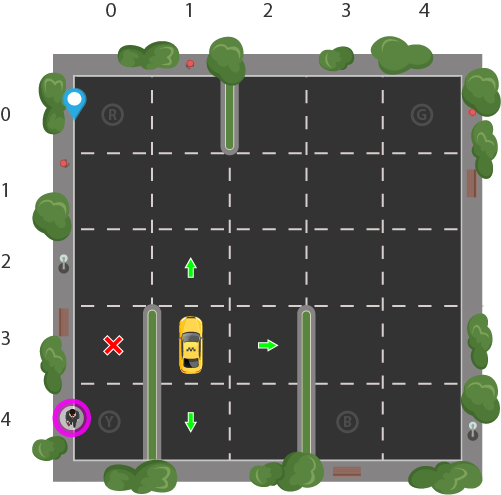

In [3]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



* **`env.reset`**: Resets the environment and returns a random initial state.
* **`env.step(action)`**: Step the environment by one timestep. Returns
    * **observation**: Observations of the environment
    * **reward**: If your action was beneficial or not
    * **done**: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
    * **info**: Additional info such as performance and latency for debugging purposes
* **`env.render`**: Renders one frame of the environment (helpful in visualizing the environment)

In [4]:
env.reset()  # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


* 0 = south
* 1 = north
* 2 = east
* 3 = west
* 4 = pickup
* 5 = dropoff

In [5]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

$$Q(state,action)\leftarrow (1 - \alpha)Q(state, action)+\alpha(reward+\gamma max_a Q(next state, all actions))$$

Where:

- $\large\alpha$ (alpha) is the learning rate ($0<\alpha\leq 1$) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- $\large\gamma$ (gamma) is the discount factor ($0\leq\gamma\leq 1$) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

In [7]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [8]:
# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

seed= 42
rng =np.random.default_rng(seed)

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if rng.random() < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.



In [9]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()  # reset environment to a new, random state
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.1
Average penalties per episode: 0.0


Hyperparameters and optimizations
The values of ($\large\alpha$) `alpha`, ($\large\gamma$) `gamma`, and ($\large\epsilon$) `epsilon` were mostly based on intuition and some "hit and trial", but there are better ways to come up with good values.

Ideally, all three should decrease over time because as the agent continues to learn, it actually builds up more resilient priors;

$\Large\alpha$: (the learning rate) should decrease as you continue to gain a larger and larger knowledge base.

$\Large\gamma$: as you get closer and closer to the deadline, your preference for near-term reward should increase, as you won't be around long enough to get the long-term reward, which means your gamma should decrease.

$\Large\epsilon$: as we develop our strategy, we have less need of exploration and more exploitation to get more utility from our policy, so as trials increase, epsilon should decrease.

In [11]:
# Play an episode

state = env.reset()  # reset environment to a new, random state
env.render()
time.sleep(0.5)
done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    clear_output(wait=True)
    env.render()
    print(reward)
    time.sleep(0.5)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
20


## Tuning the hyperparameters
A simple way to programmatically come up with the best set of values of the hyperparameter is to create a comprehensive search function (similar to grid search) that selects the parameters that would result in best reward/time_steps ratio. The reason for reward/time_steps is that we want to choose parameters which enable us to get the maximum reward as fast as possible. We may want to track the number of penalties corresponding to the hyperparameter value combination as well because this can also be a deciding factor (we don't want our smart agent to violate rules at the cost of reaching faster). A more fancy way to get the right combination of hyperparameter values would be to use Genetic Algorithms.